# Topic Modeling

We will walk through how to perform topic modeling on a corpus of Native American documents. We will use Latent Dirichlet Allocation (LDA), an unsupervised learning method in which documents are represented as a random mixture of latent topics, where each topic is a probability distribution over words. 

## Processing Corpus

In [2]:
#Set random seed for reproduction of code. 
import numpy as np
np.random.seed(42)

#Change working directory. 
import os
os.chdir("/Users/vickijtruong/Documents/DH199/Corpus")
all_files = os.listdir("/Users/vickijtruong/Documents/DH199/Corpus")
all_files.sort()
all_files.pop(0)
#print(all_files)
len(all_files)

295

In [3]:
import nltk
from nltk import tokenize
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import string

#Import stop words and add to stop words list. 
stop_words = stopwords.words('english')
more_stop = ['d','—','U','s','qf','Slfs',"'","00"]
stop_words = stop_words + more_stop
#print(stop_words)

#Read each file into the working directory. Remove stop words, non-alphabetical terms, and punctuation. Append each processed file into the docs list. 
docs = []

for file in all_files:
    with open(file,'r') as f:
        text = f.read()        
        lines_list = tokenize.word_tokenize(text)
        filtered = [w for w in lines_list if not w in stop_words and w.isalpha()] 
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in filtered]
        stripped = list(filter(None, stripped))
        docs.append(stripped)
        
#print(docs)
len(docs)

/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/opt/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


295

## Creating the Model + Topics

### Create dictionary and bag of words corpus

In [4]:
from gensim import corpora, models, similarities

#Create dictionary of words. 
dictionary = corpora.Dictionary(docs)
#Filter out tokens that appear in less than 3 documents.
dictionary.filter_extremes(no_below=3) 
#print(dictionary)
#print(len(dictionary))

#Convert convert tokenized documents to vectors 
corpus = [dictionary.doc2bow(text) for text in docs]
#print(corpus)

[[(dictionary[id],freq) for id, freq in cp]for cp in corpus]

/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


[[('After', 3),
  ('And', 1),
  ('Answer', 1),
  ('As', 1),
  ('Be', 1),
  ('Belt', 2),
  ('Brethren', 5),
  ('Consider', 1),
  ('Council', 1),
  ('Delaware', 3),
  ('Delawares', 5),
  ('Eight', 1),
  ('English', 6),
  ('French', 14),
  ('George', 1),
  ('Governors', 1),
  ('If', 1),
  ('June', 1),
  ('Loups', 1),
  ('Mingoes', 2),
  ('Nations', 9),
  ('Ohio', 3),
  ('Onondago', 2),
  ('Pennsylvania', 2),
  ('River', 1),
  ('Shawanese', 3),
  ('Six', 9),
  ('Speaker', 1),
  ('Such', 1),
  ('Susquehanna', 1),
  ('Then', 1),
  ('Therefore', 1),
  ('These', 1),
  ('They', 4),
  ('Thirteen', 1),
  ('Those', 1),
  ('Two', 1),
  ('Venango', 1),
  ('Virginia', 5),
  ('Wampum', 2),
  ('Washington', 5),
  ('We', 7),
  ('When', 3),
  ('Whereupon', 1),
  ('Why', 1),
  ('With', 1),
  ('You', 2),
  ('accomplishing', 1),
  ('according', 1),
  ('account', 2),
  ('accused', 1),
  ('acquaint', 1),
  ('active', 1),
  ('actually', 1),
  ('address', 1),
  ('addressed', 1),
  ('adjourned', 1),
  ('advanced

### Determine optimal number of topics for LDA model. Compare coherence scores across different numbers of topics.

In [6]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state = 100, passes = 25, chunksize = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [7]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=15, step=1)

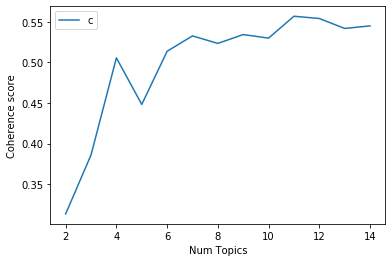

In [10]:
#Plot the graph of coherence scores across different number of topics (from 2 to 15).
import matplotlib.pyplot as plt
limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In this case, given the parameters of the model, the optimal number of topics is 11, since the coherence score is highest before it trails off again. 

### Performing LDA with optimal number of topics

In [7]:
#Parameter tuning will lead to different models. For this model, we use our corpus, dictionary, set a random state of 100 (akin to setting a seed for reproduction purposes), 11 topics (optimal number according to coherence scores), 25 passes (number of times the corpus is passed through for training), and chunk size of 100 (number of documents to be used in each training chunk).
lda = models.LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         random_state=100,
                         num_topics=11,
                         passes=25,
                         chunksize=100,
                         )
lda.show_topics()

[(0,
  '0.005*"Creeks" + 0.005*"war" + 0.004*"towns" + 0.004*"killed" + 0.003*"sent" + 0.003*"Sir" + 0.003*"party" + 0.003*"Cherokees" + 0.003*"man" + 0.003*"Major"'),
 (6,
  '0.008*"commissioners" + 0.007*"agent" + 0.006*"rations" + 0.006*"father" + 0.006*"Florida" + 0.005*"Colonel" + 0.004*"white" + 0.004*"Choctaw" + 0.004*"Mississippi" + 0.004*"children"'),
 (5,
  '0.010*"commissioners" + 0.008*"We" + 0.006*"Georgia" + 0.005*"Creek" + 0.005*"war" + 0.005*"white" + 0.004*"Creeks" + 0.004*"sent" + 0.004*"line" + 0.003*"They"'),
 (4,
  '0.017*"tribe" + 0.013*"trade" + 0.009*"Missouri" + 0.008*"intercourse" + 0.007*"traders" + 0.007*"persons" + 0.006*"citizens" + 0.006*"person" + 0.006*"And" + 0.006*"property"'),
 (7,
  '0.010*"You" + 0.010*"brothers" + 0.009*"Brother" + 0.007*"We" + 0.006*"Wyandots" + 0.006*"Brothers" + 0.006*"Great" + 0.006*"Elder" + 0.006*"chief" + 0.005*"Spirit"'),
 (2,
  '0.013*"Georgia" + 0.005*"agent" + 0.005*"commissioners" + 0.004*"We" + 0.004*"Creek" + 0.004*"

In [8]:
#Coherence for this model. 
from gensim.models import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(coherence_lda)

0.5569352542868876


## Visualization and Analysis

### Intertopic Distance Map Visualization

In [9]:
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
vis=pyLDAvis.gensim.prepare(lda,corpus,dictionary)
vis

/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.067602 -0.018087       1        1  23.752436
2      0.029717  0.067344       2        1  15.349364
8     -0.036409  0.049824       3        1  14.364381
5      0.074878  0.007278       4        1  11.750455
3     -0.168247  0.017741       5        1   7.477885
6      0.005797  0.034005       6        1   7.089435
1      0.153355 -0.082633       7        1   6.486228
9      0.028659 -0.009376       8        1   4.789546
7      0.172179 -0.083620       9        1   3.331453
4     -0.067565  0.182805      10        1   2.945892
10    -0.259966 -0.165282      11        1   2.662933, topic_info=     Category         Freq     Term        Total  loglift  logprob
1824  Default  1086.000000      For  1086.000000  30.0000  30.0000
2164  Default  1148.000000    tribe  1148.000000  29.0000  29.0000
2759  Default   881.000000       Do   881.000000  28.0000  28.0000
1979  Default  1157.000000    trade  1157.000000  27.0000  27.0000
41    Default  2618.000000       We  2618.000000  26.0000  26.0000
...       ...          ...      ...          ...      ...      ...
3019  Topic11    97.529953    April   809.147522   1.5099  -5.3128
1896  Topic11    95.939308      May   797.707031   1.5077  -5.3292
3796  Topic11   100.754356    agent  1834.286743   0.7240  -5.2802
833   Topic11    78.604980   amount  1195.760620   0.9036  -5.5285
771   Topic11    74.736801  William   610.478699   1.5255  -5.5790

[868 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
7172       4  0.971721     ALEX
11027      1  0.002303      ART
11027      2  0.018426      ART
11027      3  0.734745      ART
11027      4  0.006910      ART
...      ...       ...      ...
2176       3  0.030953  younger
2176       4  0.051589  younger
2176       7  0.154767  younger
2176       8  0.020636  younger
2176       9  0.732562  younger

[3647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 9, 6, 4, 7, 2, 10, 8, 5, 11])

### Topic Distribution Within Document

In [10]:
for i in range(len(corpus)):
    print(i,lda[corpus[i]]) #doc i is b% about topic a (results in format (a,b))

0 [(1, 0.9988243)]
1 [(1, 0.9914037)]
2 [(1, 0.9506908), (7, 0.046276137)]
3 [(1, 0.9987693)]
4 [(1, 0.97354215), (7, 0.025765825)]
5 [(1, 0.99442387)]
6 [(1, 0.9751725), (7, 0.024267854)]
7 [(1, 0.9990745)]
8 [(1, 0.99516046)]
9 [(1, 0.8626097), (7, 0.13303423)]
10 [(1, 0.9665416), (3, 0.03155302)]
11 [(0, 0.050673034), (1, 0.5397929), (5, 0.15419102), (6, 0.014578185), (7, 0.15120494), (9, 0.08789171)]
12 [(1, 0.8276207), (7, 0.12961362), (10, 0.041024085)]
13 [(1, 0.7860229), (6, 0.1405251), (7, 0.0667083)]
14 [(1, 0.9817932), (10, 0.015631098)]
15 [(1, 0.9958268)]
16 [(1, 0.9962853)]
17 [(1, 0.99726754)]
18 [(1, 0.9984286)]
19 [(1, 0.98933524)]
20 [(1, 0.9961781)]
21 [(1, 0.9945859)]
22 [(1, 0.9960616)]
23 [(1, 0.9951081)]
24 [(1, 0.99913675)]
25 [(1, 0.9862167), (7, 0.011806068)]
26 [(1, 0.9966918)]
27 [(0, 0.29634783), (1, 0.58587605), (2, 0.066922985), (4, 0.050365813)]
28 [(1, 0.9959919)]
29 [(1, 0.9917299)]
30 [(1, 0.9598031), (7, 0.036525477)]
31 [(1, 0.99758625)]
32 [(1, 0.9

Text(0.5, 1, 'Distribution of Topics For Each Document')

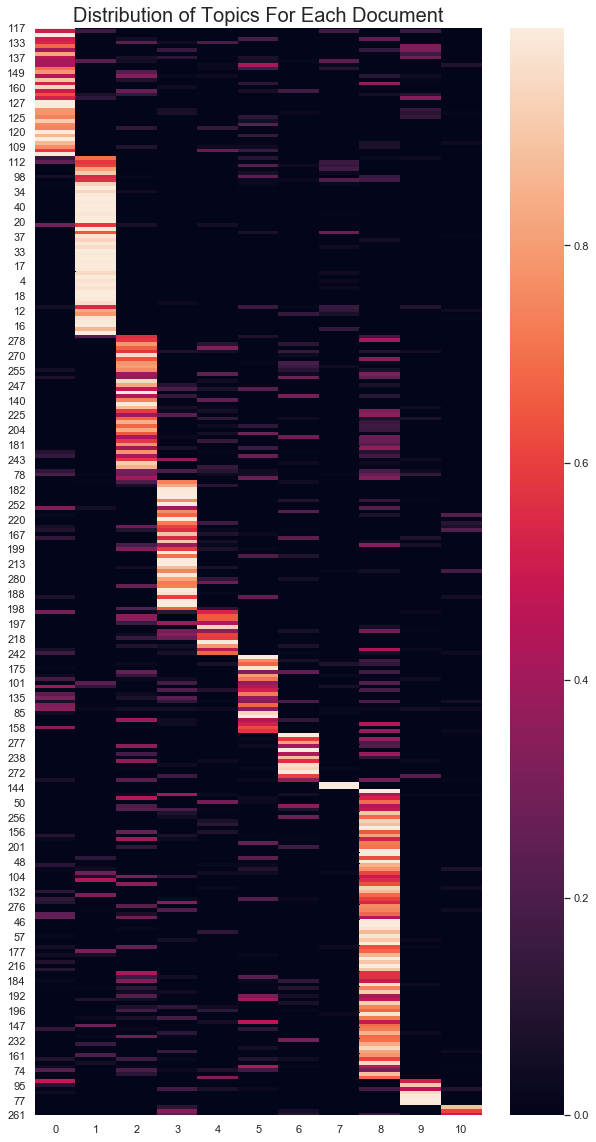

In [12]:
#Visualization of the proportion of topics in the documents (Documents are rows, topic are columns). Sum of proportion across rows will add up to 1.
#import matplotlib.pyplot as plt
import pandas as pd
num_topics=10
topics = [lda[corpus[i]] for i in range(len(docs))]
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index]) 
plt.title("Distribution of Topics For Each Document", fontsize =20)

### Documents Most Pertinent to Each Topic

In [13]:
#For each topic, which documents are most about that topic? 
for i in range(num_topics):
    print(document_topic.sort_values(i, ascending=False)[i].head(20))


120    0.999340
126    0.999243
131    0.999222
127    0.999169
117    0.998942
116    0.997707
111    0.994274
160    0.939689
102    0.916233
152    0.900777
108    0.870891
106    0.861337
86     0.822766
99     0.788872
149    0.782859
100    0.782430
109    0.763045
119    0.757768
125    0.741712
123    0.738750
Name: 0, dtype: float64
33    0.999564
24    0.999137
7     0.999075
0     0.998824
3     0.998769
18    0.998429
39    0.997786
40    0.997679
31    0.997586
17    0.997268
32    0.997174
26    0.996692
16    0.996285
20    0.996178
22    0.996062
28    0.995992
15    0.995827
8     0.995160
23    0.995108
21    0.994586
Name: 1, dtype: float64
245    0.998204
289    0.994986
270    0.966824
248    0.950366
244    0.916367
241    0.877830
217    0.851486
294    0.851119
204    0.834535
247    0.830616
260    0.801710
279    0.784006
292    0.780464
262    0.779627
181    0.765660
255    0.760314
140    0.739764
215    0.678230
221    0.673455
275    0.666717
Name: 2, dty

### Topic Frequency Among Documents

Text(0.5, 1.0, 'Topic Representation Frequency')

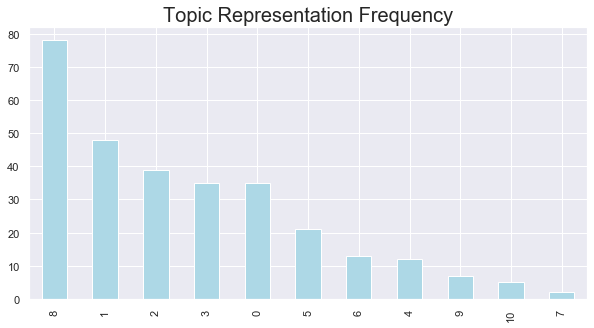

In [14]:
#Find out which topic is the most represented topic among documents. Topic 8 has the greatest number of documents that are the most related to topic 8. 
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')
plt.title("Topic Representation Frequency", fontsize =20)

References:
1. https://www.kdnuggets.com/2019/09/overview-topics-extraction-python-latent-dirichlet-allocation.html 
2. https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb
3. https://towardsdatascience.com/topic-modeling-with-gensim-a5609cefccc